# **Clustering lynx**

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import random
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from scipy.stats import norm

import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from oml.functional.metrics import calc_cmc, calc_map, calc_precision
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm

from lynx_id.data.dataset import LynxDataset
from lynx_id.data.transformations_and_augmentations import transforms
from lynx_id.data.collate import collate_single

plt.rcParams['figure.figsize'] = [20, 5]

/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/gpfs7kro/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a 

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE=}")

DEVICE='cuda'


In [4]:
random.seed(42)

## **Load data**

### Load our best model to get embeddings from image

In [5]:
model_weights = torch.load("/gpfswork/rech/ads/commun/kg_tests/model_best_0.512.pth")
model = models.resnet50(pretrained=False)
model.fc = nn.Identity()
model.load_state_dict(model_weights)
model = model.to(DEVICE)

/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Load dataset

In [6]:
# load dataset

from lynx_id.data.dataset import LynxDataset
from pathlib import Path
from lynx_id.data.transformations_and_augmentations import transforms

lynxDataset = LynxDataset(dataset_csv=Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_france.csv"), 
                      loader="pil",
                      transform=transforms,  # Define 'preprocess' earlier in your script
                      augmentation=None,
                      probabilities=[1, 0, 0],
                      mode='single',
                      device="auto")

In [7]:
print(f"{len(lynxDataset)}")

3081


In [8]:
dataloader = DataLoader(
    lynxDataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single
)

/linkhome/rech/genini01/uxp55sd/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
# Compute all embeddings
embeddings = None
model.eval()
for i, batch in enumerate(tqdm(dataloader, total=len(dataloader))):
    batch_tensor = torch.stack(batch[0]['image']).to(DEVICE).float()

    with torch.no_grad():
        batch_embeddings = model(batch_tensor)

        if embeddings is None:
            embeddings = batch_embeddings
        else:
            embeddings = torch.cat((embeddings, batch_embeddings), dim=0)

100%|██████████| 97/97 [02:18<00:00,  1.43s/it]


In [10]:
print(f"Number of individuals: {embeddings.shape[0]} | Embedding shape: {embeddings.shape[1]}")

Number of individuals: 3081 | Embedding shape: 2048


### Selection of individuals

In [174]:
# Select n images (index) from the dataset. The individual associated with the images must have at least `min_img_per_individual` images
# (threshold set experimentally).
# New individuals will then be defined
n = 100
min_img_per_individual = 1

candidates_indices = set()
data = pd.read_csv("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_france.csv")
lynx_id_counts = data['lynx_id'].value_counts()

while len(candidates_indices) < n:
    indice = random.randint(0, len(lynxDataset)-1)
    if lynx_id_counts[lynxDataset[indice][1]['lynx_id']] >= min_img_per_individual:
        candidates_indices.add(indice)
candidates_indices = torch.tensor(list(candidates_indices))

#### Candidates true lynx_id

In [175]:
# True lynx_id
candidates_lynx_id = data.loc[candidates_indices.tolist(), 'lynx_id'].tolist()

In [176]:
# Among our N candidates, we count the number of images per `lynx_id`.
count_true_label = Counter(candidates_lynx_id)

In [177]:
print(f"Among our {n} images, we have {len(count_true_label)} different lynx_ids")

Among our 100 images, we have 64 different lynx_ids


#### New individuals

In [178]:
# Select N individuals to remove from knowledge embeddings (10%)
n_individuals_to_rm = int(0.1 *len(count_true_label))

individuals_to_rm = random.choices(list(count_true_label.keys()), k=n_individuals_to_rm)
individuals_to_rm

['1780', 'F25-063=1239=1240=B683', '1317', '409', '1128', '1185']

In [179]:
# Get the indices associated with these individuals in the db of all images
# We'll delete them completely from our knowledge base so that they really are new individuals.
indices_individuals_to_rm = data.loc[data['lynx_id'].isin(individuals_to_rm)].index.tolist()
print(f"{len(indices_individuals_to_rm)=}")

len(indices_individuals_to_rm)=116


In [180]:
# Update of true `lynx_id` data 
count_new = 0
for i, element in enumerate(tqdm(candidates_lynx_id)):
    if element in individuals_to_rm:
        candidates_lynx_id[i] = "New"
        count_new += 1

print(f"{count_new=}")

100%|██████████| 100/100 [00:00<00:00, 482103.91it/s]

count_new=8


In [181]:
# Check that we have new individuals
assert "New" in candidates_lynx_id

#### Get knowledge and candidate embeddings

In [182]:
# Get their associated embeddings
embeddings_candidates = embeddings[candidates_indices].to("cpu")
print(f"Embedding candidates: {embeddings_candidates.shape}")

mask_knowledge = torch.ones(embeddings.size(0), dtype=torch.bool)
mask_knowledge[torch.cat((candidates_indices, torch.tensor(indices_individuals_to_rm)))] = False
embeddings_knowledge = embeddings[mask_knowledge].to("cpu")
print(f"Embedding knowledge images: {embeddings_knowledge.shape}")

Embedding candidates: torch.Size([100, 2048])
Embedding knowledge images: torch.Size([2873, 2048])


In [183]:
indices_knowledge = torch.nonzero(mask_knowledge).squeeze()
len(indices_knowledge)

2873

In [184]:
# Get all the `lynx_id` in our knowledge base
knowledge_lynx_id = data.loc[indices_knowledge.tolist(), 'lynx_id'].to_list()
print(f"{len(knowledge_lynx_id)}")

2873


In [185]:
unique_knowledge_lynx_id = set(knowledge_lynx_id)
print(f"In the knowledge base, we have {len(unique_knowledge_lynx_id)} lynx.")

In the knowledge base, we have 263 lynx.


In [186]:
count_knowledge_lynx_id = Counter(knowledge_lynx_id)
count_knowledge_lynx_id.most_common(20)

[('F39-060', 236),
 ('F39-054', 73),
 ('163', 72),
 ('F39-095=1556', 65),
 ('F25-008', 59),
 ('F39-061', 56),
 ('F25-067=1376', 55),
 ('F25-022=B285', 53),
 ('F01-053=997', 53),
 ('F39-086=1474=1478', 49),
 ('F01-047=922', 48),
 ('F39-093=2217=2218', 48),
 ('F39-038', 41),
 ('F01-011=933', 40),
 ('F25-055=1019=1377=R298', 39),
 ('F01-007', 38),
 ('F39-063', 37),
 ('F39-036', 36),
 ('F39-098=J1-2019-F39-059', 36),
 ('1350=B2011-57', 35)]

## **KNN**

In [187]:
# Nearest Neighbors
n_neighbors = 5
neighbors = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric="minkowski").fit(embeddings_knowledge)
distances, indices = neighbors.kneighbors(embeddings_candidates)

### Get predictions

In [188]:
# For each candidate, obtain the nearest `n_neighbors` `lynx_id`.
candidates_nearest_neighbors = [
    [knowledge_lynx_id[indice] for indice in nearest_indices]
    for nearest_indices in indices
]

### n-knn

In [189]:
# n-knn
candidates_predicted_n_knn = [Counter(candidate).most_common(1)[0][0] for candidate in candidates_nearest_neighbors]

### 1-knn

In [190]:
# 1-knn
candidates_predicted_1_knn = [candidate[0] for candidate in candidates_nearest_neighbors]

### Detecting new candidates

In this notebook, we use both a **simple threshold** defined manually and a method **based on the Gaussian distribution of the clusters**.

In [191]:
# unique_knowledge_lynx_id, knowledge_lynx_id, embeddings_knowledge
cluster_variances = {}
cluster_means = {}
for lynx in tqdm(unique_knowledge_lynx_id):
    # get all embeddings for this lynx
    lynx_idx = [i for i in range(len(knowledge_lynx_id)) if knowledge_lynx_id[i] == lynx]
    cluster_variances[lynx] = torch.var(embeddings_knowledge[lynx_idx], dim=0).tolist()
    cluster_means[lynx] = torch.mean(embeddings_knowledge[lynx_idx], dim=0).tolist()

100%|██████████| 263/263 [00:00<00:00, 649.12it/s]


In [192]:
def compute_confidence_intervals(confidence, means, variances):
    intervals = {}
    for (lynx, mean), variance in zip(tqdm(means.items(), desc="compute_confidence_intervals"), variances.values()):  # N clusters (lynx) in our knowledge base
        interval = norm.interval(confidence, loc=mean, scale=np.sqrt(variance))
        interval_formatted = tuple((element[0], element[1]) for element in zip(interval[0], interval[1]))
        intervals[lynx] = interval_formatted
    
    return intervals

In [193]:
def check_new_individual(candidates_dots, candidates_predicted, candidates_id, success_percentage_threshold=100, threshold=None, distances=None):
    candidates_predicted_local = candidates_predicted.copy()
    # Threshold
    if threshold is not None and distances is not None:
        candidates_predicted_local = [
            "New" if distance > threshold else candidate 
            for candidate, distance in zip(candidates_predicted, distances)
        ]
    
    # Gaussian
    else:
        for index, (candidate_dot, candidate_predicted) in enumerate(zip(candidates_dots, candidates_predicted)):

            if candidate_predicted in confidence_intervals.keys():
                confidence_intervals_for_candidate = confidence_intervals[candidate_predicted]

                in_confidence_interval = all(
                    interval[0] <= dot <= interval[1]
                    for dot, interval in zip(candidate_dot, confidence_intervals_for_candidate)
                )
                num_successful_cases = sum(
                    interval[0] <= dot <= interval[1]
                    for dot, interval in zip(candidate_dot, confidence_intervals_for_candidate)
                )
                min_successful_cases = int((candidate_dot.shape[0] * success_percentage_threshold) / 100)
                in_confidence_interval = num_successful_cases >= min_successful_cases

            else:
                in_confidence_interval=True

            if in_confidence_interval.item() is False:
                candidates_predicted_local[index] = "New"
        
    return candidates_predicted_local

### Compute metrics

#### Accuracy

In [194]:
# Compute some metrics
def compute_accuracy(candidates_predicted, candidates_refs, verbose=False):
    correct_predictions = 0

    for i, (p, r) in enumerate(zip(candidates_predicted, candidates_refs)):
        output = f"Candidate {i} | Prediction: {p} | True label: {r} ({count_knowledge_lynx_id[r]})"
        if p == r:
            correct_predictions += 1
            output = "\x1b[6;30;42m" + output + "\x1b[0m"
            
        if verbose:
            print(output)
        
    total_predictions = len(candidates_predicted)
    accuracy = correct_predictions / total_predictions

    return accuracy

#### CMC@k, mAP@k
We use the `open-metric-learning` module, which offers ready-made implementations of **CMC@k** and **mAP@k**.

Before calculating the metrics, we need to **adapt `candidates_nearest_neighbors` to the detection of new individuals after our calculation with confidence intervals**. Candidate i, if detected as new, will have "New" as its nearest neighbour, then its neighbours calculated via KNN will be shifted by 1. The last one is therefore forgotten.  

Example:  
candidate i: `["A", "B", "C", "D"]` detected as New -> `["New", "A", "B", "C", "D"]`

In [195]:
def update_candidates_nearest_neighbors_new(candidates_nearest_neighbors, candidates_predicted_new_individual):
    return [
            ["New"] + neighbors[0:-1] if candidate == "New" else neighbors
            for candidate, neighbors in zip(candidates_predicted_new_individual, candidates_nearest_neighbors)
    ]

In [196]:
def compute_tensor_matching_candidates(candidates_nearest_neighbors, candidates_lynx_id):
    candidates_acc_k_list = [
        [1 if candidate == candidate_id else 0 for candidate in candidates_row] for 
        candidates_row, candidate_id in zip(candidates_nearest_neighbors, candidates_lynx_id)
    ]
    return torch.tensor(candidates_acc_k_list, dtype=torch.bool)

In [197]:
def compute_mean_per_top_k(metric_output):
    metric_mean = torch.mean(torch.stack(metric_output), dim=1)
    return {k: round(v.item(), 3) for k, v in zip(top_k, metric_mean)}

In [198]:
def compute_cmc_map_metrics(candidates_nearest_neighbors, candidates_predicted, lynx_id, top_k):
    # CMC@k + mAP@k
    updated_candidates_nearest_neighbors = update_candidates_nearest_neighbors_new(candidates_nearest_neighbors, candidates_predicted)
    candidates_acc_k_tensor = compute_tensor_matching_candidates(updated_candidates_nearest_neighbors, lynx_id)

    # CMC@k
    cmc_k = calc_cmc(candidates_acc_k_tensor, top_k)
    cmc_k_mean = compute_mean_per_top_k(cmc_k)

    # mAP@k
    map_k = calc_map(candidates_acc_k_tensor, n_gt=None, top_k=top_k)
    map_k_mean = compute_mean_per_top_k(map_k)
    
    return cmc_k_mean, map_k_mean

In [199]:
top_k = (1, 2, 3, 4, 5)
confidence_levels = [0.68, 0.95, 0.997]

### Compute results

In [200]:
accuracy_list = []
accuracy_threshold = 0

cmc_values = {}
map_values = {}

### Threshold ###
print("-"*50, "New individual based on threshold", "-"*50)
candidates_predicted_new_individual = check_new_individual(
    candidates_dots=embeddings_candidates,
    candidates_predicted=candidates_predicted_1_knn,
    candidates_id=candidates_lynx_id,
    threshold=0.5,
    distances=distances[:, 0],
)

accuracy = compute_accuracy(
    candidates_predicted=candidates_predicted_new_individual,
    candidates_refs=candidates_lynx_id,
    verbose=False
)
print(f"Accuracy threshold: {accuracy}")
accuracy_threshold = accuracy

# CMC@k + mAP@k
cmc_k_mean, map_k_mean = compute_cmc_map_metrics(candidates_nearest_neighbors, candidates_predicted_new_individual, candidates_lynx_id, top_k)
print(f"{cmc_k_mean=}")
print(f"{map_k_mean=}")
cmc_values['threshold'] = list(cmc_k_mean.values())
map_values['threshold'] = list(map_k_mean.values())
    

### Gaussian ###
print("\n", "-"*50, "New individual based on gaussian", "-"*50)
for confidence in confidence_levels:
    print("*"*50, confidence, "*"*50)
    confidence_intervals = compute_confidence_intervals(
        confidence=confidence,
        means=cluster_means,
        variances=cluster_variances
    )
    results = []
    for k, prediction in {"1_knn": candidates_predicted_1_knn, f"{n_neighbors}_knn": candidates_predicted_n_knn}.items():
        candidates_predicted_new_individual = check_new_individual(
            candidates_dots=embeddings_candidates,
            candidates_predicted=prediction,
            candidates_id=candidates_lynx_id,
            success_percentage_threshold=80,
        )
        
        accuracy = compute_accuracy(
            candidates_predicted=candidates_predicted_new_individual,
            candidates_refs=candidates_lynx_id,
            verbose=False
        )
        print(f"Accuracy {k}: {accuracy}")
        results.append(accuracy)
    
        # CMC@k + mAP@k
        cmc_k_mean, map_k_mean = compute_cmc_map_metrics(candidates_nearest_neighbors, candidates_predicted_new_individual, candidates_lynx_id, top_k)
        print(f"{cmc_k_mean=}")
        print(f"{map_k_mean=}")
        
        if k == "1_knn":
            cmc_values[confidence] = list(cmc_k_mean.values())
            map_values[confidence] = list(map_k_mean.values())

    
    accuracy_list.append(results)

-------------------------------------------------- New individual based on threshold --------------------------------------------------
Accuracy threshold: 0.6
cmc_k_mean={1: 0.6, 2: 0.74, 3: 0.78, 4: 0.79, 5: 0.81}
map_k_mean={1: 0.6, 2: 0.67, 3: 0.684, 4: 0.683, 5: 0.686}

 -------------------------------------------------- New individual based on gaussian --------------------------------------------------
************************************************** 0.68 **************************************************


compute_confidence_intervals:   0%|          | 0/263 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 263/263 [00:00<00:00, 632.75it/s]


Accuracy 1_knn: 0.36
cmc_k_mean={1: 0.36, 2: 0.73, 3: 0.78, 4: 0.8, 5: 0.8}
map_k_mean={1: 0.36, 2: 0.545, 3: 0.574, 4: 0.584, 5: 0.587}
Accuracy 5_knn: 0.32
cmc_k_mean={1: 0.35, 2: 0.72, 3: 0.77, 4: 0.79, 5: 0.79}
map_k_mean={1: 0.35, 2: 0.535, 3: 0.563, 4: 0.574, 5: 0.577}
************************************************** 0.95 **************************************************


compute_confidence_intervals: 100%|██████████| 263/263 [00:00<00:00, 574.99it/s]


Accuracy 1_knn: 0.61
cmc_k_mean={1: 0.61, 2: 0.7, 3: 0.73, 4: 0.74, 5: 0.75}
map_k_mean={1: 0.61, 2: 0.655, 3: 0.661, 4: 0.658, 5: 0.659}
Accuracy 5_knn: 0.51
cmc_k_mean={1: 0.6, 2: 0.71, 3: 0.74, 4: 0.75, 5: 0.76}
map_k_mean={1: 0.6, 2: 0.655, 3: 0.661, 4: 0.658, 5: 0.659}
************************************************** 0.997 **************************************************


compute_confidence_intervals: 100%|██████████| 263/263 [00:00<00:00, 558.40it/s]


Accuracy 1_knn: 0.62
cmc_k_mean={1: 0.62, 2: 0.69, 3: 0.72, 4: 0.73, 5: 0.74}
map_k_mean={1: 0.62, 2: 0.655, 3: 0.661, 4: 0.658, 5: 0.659}
Accuracy 5_knn: 0.51
cmc_k_mean={1: 0.61, 2: 0.69, 3: 0.72, 4: 0.73, 5: 0.74}
map_k_mean={1: 0.61, 2: 0.65, 3: 0.656, 4: 0.653, 5: 0.654}


### Plot results

In [201]:
def plot_cmc_or_map(values, axes, ylabel, title):
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(axes))
    width = 0.2
    multiplier = 0

    for attribute, measurement in values.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=4)
        multiplier += 1

    ax.set_ylabel(ylabel)
    ax.set_xlabel('k')
    ax.set_title(title)
    ax.set_xticks(x + (width * 1.5), axes)
    ax.legend(loc='upper left', ncols=4)
    plt.show()

#### CMC@k

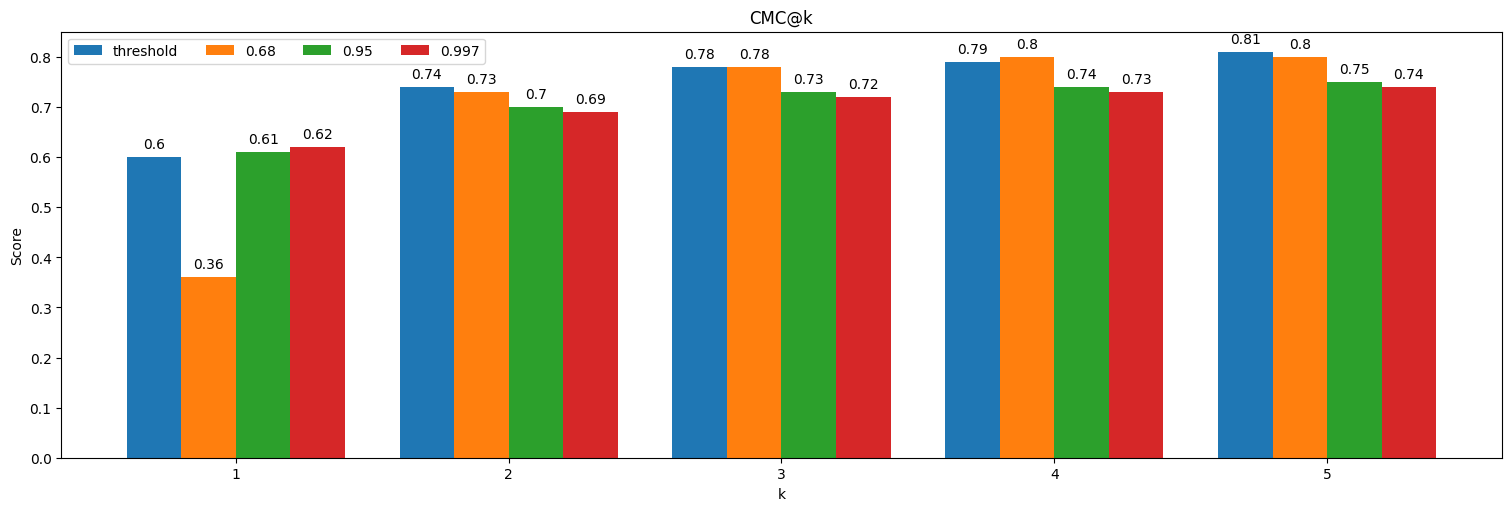

In [202]:
# CMC@k
plot_cmc_or_map(cmc_values, top_k, 'Score', 'CMC@k')

#### mAP@k

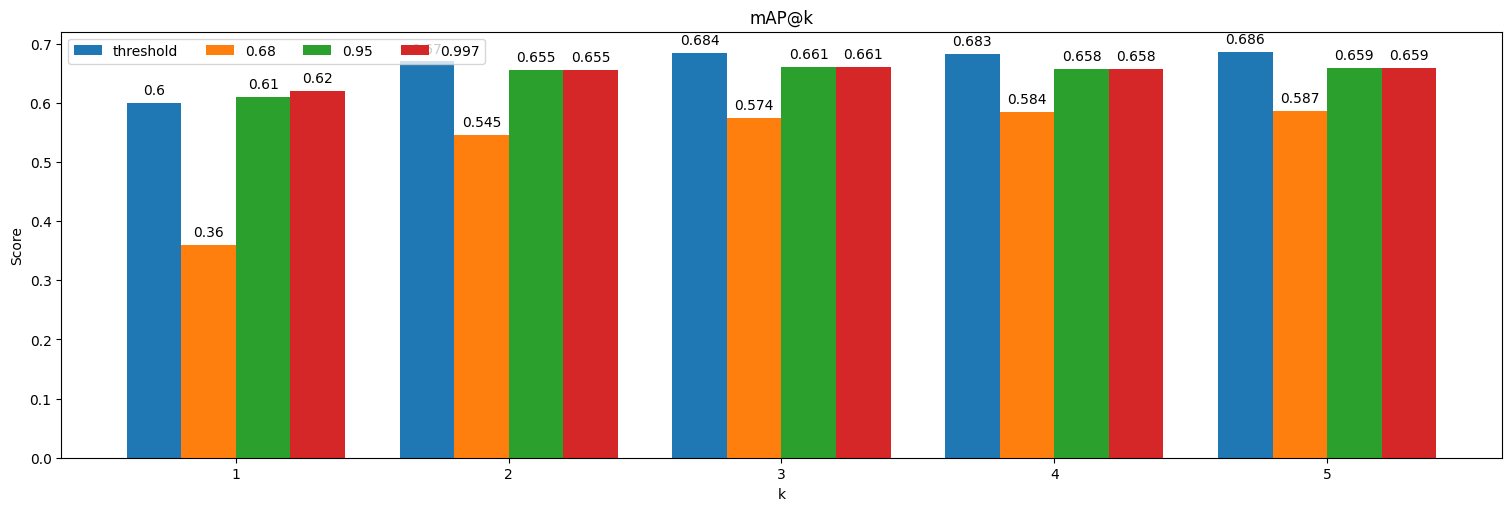

In [203]:
# mAP@k
plot_cmc_or_map(map_values, top_k, 'Score', 'mAP@k')

#### Accuracy

To compare the candidate's choice between 1-knn and n-knn. If n-knn, the lynx_id of the current image will be the one found most often among the neighbours.

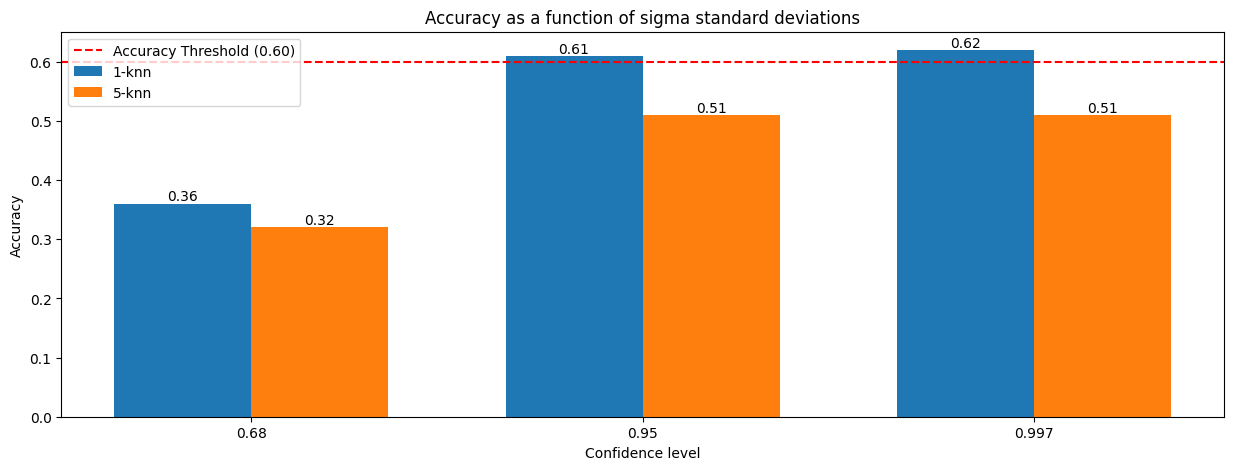

In [204]:
# Accuracy plot
accuracy_list_t = list(zip(*accuracy_list))

plt.rcParams["figure.figsize"] = (15,5)
fig, ax = plt.subplots()

width = 0.35

# Gaussian
bar1 = ax.bar(range(len(accuracy_list)), accuracy_list_t[0], width=width, label='1-knn')
bar2 = ax.bar([x + width for x in range(len(accuracy_list))], accuracy_list_t[1], width=width, label=f'{n_neighbors}-knn')

# Classic threshold
ax.axhline(y=accuracy_threshold, color='r', linestyle='--', label=f'Accuracy Threshold ({accuracy_threshold:.2f})')
ax.legend()

ax.set_xticks([x + width / 2 for x in range(len(accuracy_list))])
ax.set_xticklabels(confidence_levels)
ax.set_xlabel('Confidence level')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of sigma standard deviations')

ax.legend()

def add_text_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_text_labels(bar1)
add_text_labels(bar2)

plt.show()